In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import re
import matplotlib.pyplot as plt

# 1. 收集数据

## 1.1 收集狗种类预测数据

In [2]:
url = 'https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/image-predictions.tsv'

In [3]:
# 获取狗种类预测数据并写入DataFrame
df_type = pd.read_table(url, sep='\t', header=0)

In [4]:
df_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [5]:
df_type.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [6]:
df_type.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


## 收集每条推特的转发数和喜欢数

In [7]:
with open('tweet_json.txt', 'r') as files:
    tweets = []
    data = files.readlines()
    for line in data:
        x = json.loads(line)
        tweet = {}
        tweet['tweet_id'] = x['id']
        tweet['favorite_count'] = x['favorite_count']
        tweet['retweet_count'] = x['retweet_count']
        tweets.append(tweet)

In [8]:
df_tweets = pd.DataFrame(tweets)

In [9]:
df_tweets.head()

,favorite_count,retweet_count,tweet_id
0,39492,8842,892420643555336193
1,33786,6480,892177421306343426
2,25445,4301,891815181378084864
3,42863,8925,891689557279858688
4,41016,9721,891327558926688256


## 1.3 收集每条推特的完整数据

In [10]:
df = pd.read_csv('twitter-archive-enhanced.csv')

In [11]:
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [13]:
df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [14]:
# tidiness issue 1
# 使用编程评估（DataFrame.describe）发现有些推特为转发，有181条推特有转发数据，比如retweeted_status_user_id
# 此为数据格式问题，这些条目应该予以删除
# 转发的推特的id记录在df_retweet_id
df_retweet_id = df[df['retweeted_status_user_id'].isnull()==False]['tweet_id']

In [15]:
len(df_retweet_id)

181

# 2. 评估及清理数据

In [16]:
print('Length of df_type: ' + str(len(df_type)))
print('Length of df_tweets: ' + str(len(df_tweets)))
print('Length of df: ' + str(len(df)))

Length of df_type: 2075
Length of df_tweets: 2352
Length of df: 2356


In [17]:
df_type_copy = df_type.copy()
df_tweets_copy = df_tweets.copy()
df_copy = df.copy()

In [18]:
df_copy = df_copy.join(df_type_copy.jpg_url)
df_copy = df_copy.join(df_type_copy.p1)
df_copy = df_copy.join(df_type_copy.p1_dog)
df_copy = df_copy.join(df_type_copy.p2)
df_copy = df_copy.join(df_type_copy.p2_dog)
df_copy = df_copy.join(df_type_copy.p3)
df_copy = df_copy.join(df_type_copy.p3_dog)
df_copy = df_copy.join(df_tweets_copy.retweet_count)
df_copy = df_copy.join(df_tweets_copy.favorite_count)
df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])

In [19]:
df_copy = df_copy.drop([
                        'in_reply_to_status_id', 
                        'in_reply_to_user_id', 
                        'source', 
                        'retweeted_status_id', 
                        'retweeted_status_timestamp', 
                        'expanded_urls'], 
                        axis=1)

In [20]:
df_copy['rating_numerator'] = pd.to_numeric(df_copy['rating_numerator'], 
                                                     errors='ignore', 
                                                     downcast='float')
df_copy['rating_denominator'] = pd.to_numeric(df_copy['rating_denominator'], 
                                                     errors='ignore', 
                                                     downcast='float')

In [21]:
df_copy_original = df_copy.copy()

In [22]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 20 columns):
tweet_id                    2356 non-null int64
timestamp                   2356 non-null datetime64[ns]
text                        2356 non-null object
retweeted_status_user_id    181 non-null float64
rating_numerator            2356 non-null float32
rating_denominator          2356 non-null float32
name                        2356 non-null object
doggo                       2356 non-null object
floofer                     2356 non-null object
pupper                      2356 non-null object
puppo                       2356 non-null object
jpg_url                     2075 non-null object
p1                          2075 non-null object
p1_dog                      2075 non-null object
p2                          2075 non-null object
p2_dog                      2075 non-null object
p3                          2075 non-null object
p3_dog                      2075 non-null object
re

In [23]:
df_copy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 20 columns):
tweet_id                    2356 non-null int64
timestamp                   2356 non-null datetime64[ns]
text                        2356 non-null object
retweeted_status_user_id    181 non-null float64
rating_numerator            2356 non-null float32
rating_denominator          2356 non-null float32
name                        2356 non-null object
doggo                       2356 non-null object
floofer                     2356 non-null object
pupper                      2356 non-null object
puppo                       2356 non-null object
jpg_url                     2075 non-null object
p1                          2075 non-null object
p1_dog                      2075 non-null object
p2                          2075 non-null object
p2_dog                      2075 non-null object
p3                          2075 non-null object
p3_dog                      2075 non-null object
re

In [24]:
df_copy.describe()

,tweet_id,retweeted_status_user_id,rating_numerator,rating_denominator,retweet_count,favorite_count
count,2.356000e+03,1.810000e+02,2356.000000,2356.000000,2352.000000,2352.000000
mean,7.427716e+17,1.241698e+16,13.126486,10.455433,3134.932398,8109.198980
std,6.856705e+16,9.599254e+16,45.876648,6.745237,5237.846296,11980.795669
min,6.660209e+17,7.832140e+05,0.000000,0.000000,0.000000,0.000000
25%,6.783989e+17,4.196984e+09,10.000000,10.000000,618.000000,1417.000000
50%,7.196279e+17,4.196984e+09,11.000000,10.000000,1456.500000,3596.500000
75%,7.993373e+17,4.196984e+09,12.000000,10.000000,3628.750000,10118.000000
max,8.924206e+17,7.874618e+17,1776.000000,170.000000,79116.000000,132318.000000


## Tidiness issue 1

### 定义
使用编程评估（DataFrame.describe）发现有些推特为转发，有181条推特有转发数据，比如retweeted_status_user_id，这些数据需要删除。

### 清洗代码
删除为转发的条目

In [25]:
# 转发的推特的id记录在df_retweet_id
df_retweet_id = df_copy[df_copy['retweeted_status_user_id'].isnull()==False]['tweet_id']

# 删除为转发的推特
for id in list(df_copy['tweet_id']):
    if id in list(df_retweet_id):
        df_copy = df_copy[df_copy['tweet_id']!=id]

### 测试

In [26]:
# 查看df_copy是否还存有转发的推特
len(df_copy[df_copy['retweeted_status_user_id'].isnull()==False]['tweet_id'])

0

## Tidiness issue 2

### 定义
使用目测评估发现stage分为四列。因为这是同一种类型的数据，所以不需要分为四列，应合并唯一列。

### 清洗代码

In [27]:
# 记录每条推特中狗的stage，同时使用编程评估发现有些狗有多个stage。
# 同时也用multi_stages变量记录下拥有多个stage的狗的tweet_id和相应的stages，为后续处理问题做准备。
stages = []
for i in range(2356):
    temp = []
    if i in df_copy.index:
        if df_copy['doggo'][i] != 'None':
            temp.append(df_copy['doggo'][i])
        if df_copy['floofer'][i] != 'None':
            temp.append(df_copy['floofer'][i])
        if df_copy['pupper'][i] != 'None':
            temp.append(df_copy['pupper'][i])
        if df_copy['puppo'][i] != 'None':
            temp.append(df_copy['puppo'][i])
        if len(temp)>=2:
            stages.append({'tweet_id': df_copy['tweet_id'][i], 'stage': temp})
        elif len(temp)==1:
            stages.append({'tweet_id': df_copy['tweet_id'][i], 'stage': temp[0]})
        else:
            stages.append({'tweet_id': df_copy['tweet_id'][i], 'stage': np.nan})

# 将狗的四列stage合并为一列
df_stages = pd.DataFrame(stages, columns=['tweet_id', 'stage'])
df_stages.head()
df_copy = df_copy.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)
df_copy.insert(loc=6, column='stage', value=df_stages['stage'])

### 测试

In [28]:
# stage为非空值的推特有317条
len(df_copy[pd.isnull(df_copy['stage']) == False])

317

In [29]:
# 拥有多个stage的推特将多个stage以列表形式记录
df_copy[pd.isnull(df_copy['stage']) == False]

,tweet_id,timestamp,text,retweeted_status_user_id,rating_numerator,rating_denominator,stage,name,jpg_url,p1,p1_dog,p2,p2_dog,p3,p3_dog,retweet_count,favorite_count
9,890240255349198849,2017-07-26 15:59:51,This is Cassie. She is a college pup. Studying...,NaN,14.0,10.0,doggo,Cassie,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,miniature_poodle,True,komondor,True,soft-coated_wheaten_terrier,True,7684.0,32467.0
12,889665388333682689,2017-07-25 01:55:32,Here's a puppo that seems to be on the fence a...,NaN,13.0,10.0,puppo,None,https://pbs.twimg.com/media/CT5d9DZXAAALcwe.jpg,Walker_hound,True,English_foxhound,True,Ibizan_hound,True,8502.0,38745.0
14,889531135344209921,2017-07-24 17:02:04,This is Stuart. He's sporting his favorite fan...,NaN,13.0,10.0,puppo,Stuart,https://pbs.twimg.com/media/CT5w9gUW4AAsBNN.jpg,bloodhound,True,German_shepherd,True,malinois,True,2309.0,15329.0
28,886680336477933568,2017-07-16 20:14:00,This is Derek. He's late for a dog meeting. 13...,NaN,13.0,10.0,pupper,Derek,https://pbs.twimg.com/media/CT-NvwmW4AAugGZ.jpg,black-and-tan_coonhound,True,bloodhound,True,flat-coated_retriever,True,3297.0,21488.0
40,884562892145688576,2017-07-11 00:00:02,This is Kevin. He's just so happy. 13/10 what ...,NaN,13.0,10.0,doggo,Kevin,https://pbs.twimg.com/media/CUCQTpEWEAA7EDz.jpg,German_shepherd,True,beagle,True,bloodhound,True,5836.0,27443.0
43,884162670584377345,2017-07-09 21:29:42,Meet Yogi. He doesn't have any important dog m...,NaN,12.0,10.0,floofer,Yogi,https://pbs.twimg.com/media/CUDeDoWUYAAD-EM.jpg,seat_belt,False,miniature_pinscher,True,Chihuahua,True,3559.0,22269.0
46,883360690899218434,2017-07-07 16:22:55,Meet Grizzwald. He may be the floofiest floofe...,NaN,13.0,10.0,pupper,Grizzwald,https://pbs.twimg.com/media/CUD3A7YWoAA82N0.jpg,English_setter,True,Brittany_spaniel,True,Ibizan_hound,True,6900.0,37810.0
53,881906580714921986,2017-07-03 16:04:48,This is Rey. He's a Benebop Cumberfloof. 12/10...,NaN,12.0,10.0,pupper,Rey,https://pbs.twimg.com/media/CUG0bC0U8AAw2su.jpg,hyena,False,African_hunting_dog,False,coyote,False,11026.0,51390.0
67,879376492567855104,2017-06-26 16:31:08,This is Jack AKA Stephen Furry. You're not sco...,NaN,12.0,10.0,puppo,Jack,https://pbs.twimg.com/media/CUJK18UWEAEg7AR.jpg,vizsla,True,Chesapeake_Bay_retriever,True,Weimaraner,True,7118.0,0.0
75,878281511006478336,2017-06-23 16:00:04,Meet Shadow. In an attempt to reach maximum zo...,NaN,13.0,10.0,pupper,Shadow,https://pbs.twimg.com/media/CUMZnmhUEAEbtis.jpg,Saint_Bernard,True,Leonberg,True,golden_retriever,True,7118.0,42743.0


## Quality issue 1

### 定义
使用编程评估（DataFrame.info）发现有279条推特的jpg_url为空值，这些推特无法使用神经网络预测图片是否为狗，故需要删除。

In [30]:
len(df_copy[pd.isnull(df_copy['jpg_url']) == True])

279

### 清洗代码

In [31]:
# 记录没有图片url的id
no_jpg_id = df_copy[df_copy['jpg_url'].isnull()]['tweet_id']

In [32]:
# 删除没有图片的数据
for id in list(df_copy['tweet_id']):
    if id in list(no_jpg_id):
        df_copy = df_copy[df_copy['tweet_id']!=id]
print(len(df_copy))

1896


### 测试

In [33]:
len(df_copy[pd.isnull(df_copy['jpg_url']) == True])

0

## Quality issue 2

### 定义
有些条目中name首字母没有大写、有些长度少于2个字母，需要找出这些条目，判断是名字截取错误还是没有名字；若名字错误，删除。

In [34]:
# 使用编程评估找出首字母没有大写的、长度少于2个字母的或名字为空值的name
not_upper_name_id = []
length_2 = []
for i in range(2356):
    if i in df_copy.index:
        if df_copy['name'][i][0].isupper()==False:
            not_upper_name_id.append({'tweet_id': df_copy['tweet_id'][i], 'name': df_copy['name'][i]})
        elif len(df_copy['name'][i])<=2:
            length_2.append({'tweet_id': df_copy['tweet_id'][i], 'name': df_copy['name'][i]})
print('Number of wrong names: ' + str(len(not_upper_name_id)))
print('Number of names having length less than 2: ' + str(len(length_2)))

Number of wrong names: 68
Number of names having length less than 2: 11


In [35]:
# 通过目测评估，首字母没有大写的name都是错误的名字
not_upper_name_id = pd.DataFrame(not_upper_name_id, columns=['tweet_id', 'name'])

In [36]:
# 记录错误的名字（首字母没有大写）和没有名字的id
wrong_name_id = not_upper_name_id['tweet_id']
NaN_name_id = df_copy[df_copy['name']=='None']['tweet_id']

In [37]:
# 首字母大写但长度过短（字母数少于2）的名字，总计有11个；经目测评估，这11个中有相当一部分都不是有效的名字，比如O、Mo、Bo、JD。
length_2

[{'name': 'Mo', 'tweet_id': 825876512159186944},
 {'name': 'Bo', 'tweet_id': 819004803107983360},
 {'name': 'Bo', 'tweet_id': 804026241225523202},
 {'name': 'Bo', 'tweet_id': 789137962068021249},
 {'name': 'O', 'tweet_id': 776201521193218049},
 {'name': 'Al', 'tweet_id': 770414278348247044},
 {'name': 'Bo', 'tweet_id': 761004547850530816},
 {'name': 'Bo', 'tweet_id': 749996283729883136},
 {'name': 'Bo', 'tweet_id': 681694085539872773},
 {'name': 'Ed', 'tweet_id': 672834301050937345},
 {'name': 'JD', 'tweet_id': 671542985629241344}]

In [38]:
length_2 = pd.DataFrame(length_2, columns=['tweet_id', 'name'])

In [39]:
# 由于此质量问题记录条数较少，使用目测评估
# 记录名字长度短于2的id，考虑到Al、Ed可能是“正确的”英文名，这几条推特不视为质量问题
length_2 = length_2[length_2['name']!='Ed']
length_2 = length_2[length_2['name']!='Al']
length_2_id = length_2['tweet_id']

### 清洗代码

In [40]:
# 找出wrong_name_id中实际包含了名字但是没有正确截取的推特，通过“This is”，然后目测
for id in list(wrong_name_id):
    index_num = df_copy[df_copy['tweet_id'] == id].index[0]
    if "This is" in df_copy['text'][index_num]:
        print(index_num)
        print(df_copy['text'][index_num])
        print('********************************')
        print('********************************')

22
I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba
********************************
********************************
169
We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9
********************************
********************************
193
Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x
********************************
********************************
335
There's going to be a dog terminal at JFK Airport. This is not a drill. 10/10  
https://t.co/dp5h9bCwU7
********************************
********************************
369
Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK
********************************
******************************

In [41]:
# 记录推特中有name但是未被正确截取的index number
name_list = [369, 852, 992, 1853, 2034, 2066]

In [42]:
# 找出wrong_name_id中实际包含了名字但是没有正确截取的推特，通过“named”，然后目测
for id in list(wrong_name_id):
    index_num = df_copy[df_copy['tweet_id'] == id].index[0]
    if "named" in df_copy['text'][index_num] and index_num not in name_list:
        print(index_num)
        print(df_copy['text'][index_num])
        print('********************************')
        print('********************************')

1955
This is a Lofted Aphrodisiac Terrier named Kip. Big fan of bed n breakfasts. Fits perfectly. 10/10 would pet firmly https://t.co/gKlLpNzIl3
********************************
********************************


In [43]:
# 记录推特中有name但是未被正确截取的index number
name_list = name_list + [1955]

In [44]:
# 修正wrong_name_id
for id in list(wrong_name_id):
    index_num = df_copy[df_copy['tweet_id'] == id].index[0]
    if index_num in name_list:
        wrong_name_id = wrong_name_id[wrong_name_id!=id]

In [45]:
# 有7条推特是有name但是没有被正确记录
len(wrong_name_id)

61

In [46]:
# 删除名字首字母没有大写或长度少于2的推特
# wrong_name_id, NaN_name_id, length_2_id
for id in list(df_copy['tweet_id']):
    if id in list(wrong_name_id):
        df_copy = df_copy[df_copy['tweet_id']!=id]

for id in list(df_copy['tweet_id']):
    if id in list(length_2_id):
        df_copy = df_copy[df_copy['tweet_id']!=id]

print(len(df_copy))

1826


### 测试

In [47]:
wrong_name_list = []
len_2_list = []
for i in range(2356):
    if i in df_copy.index:
        if df_copy['name'][i][0].isupper()==False:
            wrong_name_list.append(i)
        elif len(df_copy['name'][i])<=2:
            len_2_list.append(df_copy['name'][i])
print('Number of wrong names: ' + str(len(wrong_name_list)))
# 查看清洗后剩余的首字母没大写的条目index number与之前目测评估得到的名字为正确截取的条目的index number是否相同；经检验，是相同的。
print(wrong_name_list.sort() == name_list.sort())
print('Number of names having length less than 2: ' + str(len(len_2_list)))
# 查看清洗后剩余的长度少于等于2的名字是否与之前目测评估长度少于等于2但正确的名字是否一致；经检验，是一致的。
print(len_2_list)

Number of wrong names: 7
True
Number of names having length less than 2: 2
['Al', 'Ed']


## Quality issue 3

### 定义
使用编程评估（DataFrame.info）发现原始数据中（df_copy_original）有4条推特没有转发数据(retweet_count)，应删除这些数据。

In [48]:
len(df_copy_original[pd.isnull(df_copy_original['retweet_count'])==True])

4

### 清洗代码
在前序几个问题的数据清洗中，已经将没有转发数据的这4条推特清洗掉了，故此处无需清洗。

### 测试

In [49]:
# 检验是否还有转发数据为0的推特。检验结果为没有此类条目了。
df_copy[df_copy['retweet_count'].isnull()]['tweet_id']

Series([], Name: tweet_id, dtype: int64)

## Quality issue 4

### 定义
使用编程评估（DataFrame.info）发现原始数据中（df_copy_original）有4条推特没有喜欢数数据(favorite_count)，应删除这些数据。

In [50]:
len(df_copy_original[pd.isnull(df_copy_original['favorite_count'])==True])

4

### 清洗代码
在前序几个问题的数据清洗中，已经将没有喜欢数数据的这4条推特清洗掉了，故此处无需清洗。

### 测试

In [51]:
# 检验是否还有喜欢数数据为0的推特。检验结果为没有此类条目了。
df_copy[df_copy['favorite_count'].isnull()]['tweet_id']

Series([], Name: tweet_id, dtype: int64)

## Quality issue 5

### 定义
使用编程评估（DataFrame.describe）发现评分的分母最小值为0，然后通过pandas dataframe indexing and slicing筛选出这些条目。
发现tweet_id为835246439529840640，评分的分母为0，但推特正文中的有效评分为13/10，故需要修正评分。

In [52]:
df_copy[df_copy['rating_denominator']==0.0]['tweet_id']

313    835246439529840640
Name: tweet_id, dtype: int64

In [53]:
df_copy[df_copy['rating_denominator']==0.0]['text'][313]

"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho"

### 清洗代码

In [54]:
# 更正该条目的评分分子和分母
df_copy.set_value(index=313, col='rating_numerator', value=13)
df_copy.set_value(index=313, col='rating_denominator',  value=10)

,tweet_id,timestamp,text,retweeted_status_user_id,rating_numerator,rating_denominator,stage,name,jpg_url,p1,p1_dog,p2,p2_dog,p3,p3_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,NaN,13.0,10.0,NaN,Phineas,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,True,collie,True,Shetland_sheepdog,True,8842.0,39492.0
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,NaN,13.0,10.0,NaN,Tilly,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,True,miniature_pinscher,True,Rhodesian_ridgeback,True,6480.0,33786.0
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,NaN,12.0,10.0,NaN,Archie,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,True,malinois,True,bloodhound,True,4301.0,25445.0
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,NaN,13.0,10.0,NaN,Darla,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,True,redbone,True,miniature_pinscher,True,8925.0,42863.0
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,NaN,12.0,10.0,NaN,Franklin,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,True,Rottweiler,True,Doberman,True,9721.0,41016.0
5,891087950875897856,2017-07-29 00:08:17,Here we have a majestic great white breaching ...,NaN,13.0,10.0,NaN,None,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,Bernese_mountain_dog,True,English_springer,True,Greater_Swiss_Mountain_dog,True,3240.0,20548.0
6,890971913173991426,2017-07-28 16:27:12,Meet Jax. He enjoys ice cream so much he gets ...,NaN,13.0,10.0,NaN,Jax,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,box_turtle,False,mud_turtle,False,terrapin,False,2142.0,12053.0
7,890729181411237888,2017-07-28 00:22:40,When you watch your owner call another dog a g...,NaN,13.0,10.0,NaN,None,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,chow,True,Tibetan_mastiff,True,fur_coat,False,19548.0,66596.0
8,890609185150312448,2017-07-27 16:25:51,This is Zoey. She doesn't want to be one of th...,NaN,13.0,10.0,NaN,Zoey,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,shopping_cart,False,shopping_basket,False,golden_retriever,True,4403.0,28187.0
9,890240255349198849,2017-07-26 15:59:51,This is Cassie. She is a college pup. Studying...,NaN,14.0,10.0,doggo,Cassie,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,miniature_poodle,True,komondor,True,soft-coated_wheaten_terrier,True,7684.0,32467.0


### 测试

In [55]:
# 查看分子的值，已更正为正确值
df_copy[df_copy['tweet_id'] == 835246439529840640]['rating_numerator'][313]

13.0

In [56]:
# 查看分母的值，已更正为正确值
df_copy[df_copy['tweet_id'] == 835246439529840640]['rating_denominator'][313]

10.0

## Quality issue 6

### 定义
使用编程评估（dataframe indexing and slicing）发现被预测为不是狗的条目，前三分类都预测为“不是狗”的图片中，有些不是狗，有些虽然是狗，但是图片中的狗较难识别。
由于此项质量问题涉及到神经网络预测的准确性，且条目数量较多，很难高效的通过目测观察剔除。因此，决定先全部剔除前三分类全部被预测为“不是狗”的推特，即假设所有神经网络预测Top-3分类不含狗的图片中绝大部分并不是狗。

In [57]:
# 总计有275条前三分类都预测为“不是狗”的推特
true_dog=df_copy[df_copy['p1_dog']==False]
true_dog = true_dog[true_dog['p2_dog']==False]
true_dog = true_dog[true_dog['p3_dog']==False]
print('Number of pictures that have no dog in top-3 pred: ' + str(len(true_dog)))

# 记录不是狗的推特id
top_3_no_dog_id = true_dog['tweet_id']

Number of pictures that have no dog in top-3 pred: 275


### 清洗代码

In [58]:
# 删除不是狗图片的数据
for id in list(df_copy['tweet_id']):
    if id in list(top_3_no_dog_id):
        df_copy = df_copy[df_copy['tweet_id']!=id]

print(len(df_copy))

1551


### 测试

In [59]:
# 前三分类都预测为“不是狗”的推特已全部清理
true_dog=df_copy[df_copy['p1_dog']==False]
true_dog = true_dog[true_dog['p2_dog']==False]
true_dog = true_dog[true_dog['p3_dog']==False]
print('Number of pictures that have no dog in top-3 pred: ' + str(len(true_dog)))

Number of pictures that have no dog in top-3 pred: 0


## Quality issue 7

### 定义
有些狗有多个stages，而理论上每条狗应该只有一个。需要找出这些狗的正确stage。有这个问题的数据条目为6条。

In [60]:
# 经过前序问题的数据清洗，还有6条数据拥有多个stage
multi_stages_2 = []
for i in range(2356):
    temp = []
    if i in df_copy.index:
        if type(df_copy['stage'][i]) == list:
            multi_stages_2.append(df_copy['tweet_id'][i])
            
len(multi_stages_2)

6

### 清洗代码

In [61]:
# 目测图片判断stage并替换原数据表中数据
# 经过前序问题中的数据清理步骤，目前还剩9条数据为多个stage。
stage_list = []
for id in list(df_copy['tweet_id']):
    if id in multi_stages_2:
        stage_list.append(id)
        print(id)
        print(df_copy[df_copy['tweet_id']==id]['jpg_url'])
        print('*********************************')

858843525470990336
172    https://pbs.twimg.com/media/CUjETvDVAAI8LIy.jpg
Name: jpg_url, dtype: object
*********************************
817120970343411712
467    https://pbs.twimg.com/media/CV4_8FgXAAQOj4S.jpg
Name: jpg_url, dtype: object
*********************************
816091915477250048
474    https://pbs.twimg.com/media/CV6atgoWcAEsdv6.jpg
Name: jpg_url, dtype: object
*********************************
802239329049477120
567    https://pbs.twimg.com/media/CWnznDTU4AAa-6P.jpg
Name: jpg_url, dtype: object
*********************************
798925684722855936
593    https://pbs.twimg.com/media/CW37xZbUoAAUXe5.jpg
Name: jpg_url, dtype: object
*********************************
775729183532220416
781    https://pbs.twimg.com/media/CZNexghWAAAYnT-.jpg
Name: jpg_url, dtype: object
*********************************


In [62]:
# 对应stage_list的stage，根据目测判断
actual_stage = ['pupper', 'puppo', 'floofer', 'pupper', 'puppo', 'doggo']

In [63]:
# 将有多个stage的数据替换为正确的stage
for i in range(len(stage_list)):
    index_num = df_copy[df_copy['tweet_id']==stage_list[i]].index.values[0]
    df_copy['stage'][index_num] = actual_stage[i]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### 测试

In [64]:
# 拥有多个stage的6条推特已全部更正为一个stage。
for i in range(len(stage_list)):
    index_num = df_copy[df_copy['tweet_id']==stage_list[i]].index.values[0]
    print(df_copy['stage'][index_num])

pupper
puppo
floofer
pupper
puppo
doggo


## Quality issue 8

### 定义
有些条目的评分有问题。text有两个评分时只选取了第一个评分；有些评分的分母不等于10；有些条目中有多个多个数值，但是截取的是非评分数值（比如9/11）。这些条目都需要修正为正确的评分。有两个评分的条目，修正后评分为两者的平均值。

In [65]:
# 检验正则表达式是否正确
re.findall(r"[-+]?\d*\.\d+|\d+", '11.27/10 this is a trial 1000/0.999')

['11.27', '10', '1000', '0.999']

In [66]:
# 先找出有多于两个数字的推特条目，总计89条。
multiple_rating_id = []
for i in range(2356):
    if i in df_copy.index:
        if "https:" in df_copy['text'][i]:
            source_index = df_copy['text'][i].index("https:")
            if len(re.findall(r"[-+]?\d*\.\d+|\d+", df_copy['text'][i][5:source_index]))>2:
                multiple_rating_id.append({'tweet_id': df_copy['tweet_id'][i], 
                                           'rating': re.findall(r"[-+]?\d*\.\d+|\d+", df_copy['text'][i][5:source_index]), 
                                           'rating_numerator': df_copy['rating_numerator'][i], 
                                           'rating_denominator': df_copy['rating_denominator'][i],
                                           'text': df_copy['text'][i]})
        else:
            if len(re.findall(r"[-+]?\d*\.\d+|\d+", df_copy['text'][i][5:]))>2:
                multiple_rating_id.append({'tweet_id': df_copy['tweet_id'][i], 
                                           'rating': re.findall(r"[-+]?\d*\.\d+|\d+", df_copy['text'][i][5:]), 
                                           'rating_numerator': df_copy['rating_numerator'][i], 
                                           'rating_denominator': df_copy['rating_denominator'][i],
                                           'text': df_copy['text'][i]})

In [67]:
len(multiple_rating_id)

89

In [68]:
multiple_rating_id

[{'rating': ['17', '10', '13', '10'],
  'rating_denominator': 10.0,
  'rating_numerator': 17.0,
  'text': '@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s',
  'tweet_id': 881633300179243008},
 {'rating': ['150', '12', '10'],
  'rating_denominator': 10.0,
  'rating_numerator': 12.0,
  'text': "Meet Elliot. He's a Canadian Forrest Pup. Unusual number of antlers for a dog. Sneaky tongue slip to celebrate #Canada150. 12/10 would pet https://t.co/cgwJwowTMC",
  'tweet_id': 881268444196462592},
 {'rating': ['236', '13', '10'],
  'rating_denominator': 10.0,
  'rating_numerator': 13.0,
  'text': "PUPDATE: I'm proud to announce that Toby is 236 days sober. Pupgraded to a 13/10. We're all very proud of you, Toby https://t.co/a5OaJeRl9B",
  'tweet_id': 844979544864018432},
 {'rating': ['3', '11', '10'],
  'rating_denominator': 10.0,
  'rating_numerator': 11.0,
  'text': "This is Hank. He's been outside for 3 minutes and already made a friend. Way to go 

In [69]:
# 然后找出denominator数值不等于10的条目，总计4条。
# 同时找出text中数字等于或多于4个的条目，总计27条。
wrong_denominator = []
double_rating = []

for i in multiple_rating_id:
    if i['rating_denominator'] != 10:
        wrong_denominator.append({'tweet_id': i['tweet_id'], 
                                  'rating_denominator': i['rating_denominator'], 
                                  'rating_numerator': i['rating_numerator'], 
                                  'text': i['text']})
    elif len(i['rating'])>=4:
        double_rating.append({'tweet_id': i['tweet_id'], 
                                  'rating_denominator': i['rating_denominator'], 
                                  'rating_numerator': i['rating_numerator'], 
                                  'text': i['text']})

In [70]:
wrong_denominator

[{'rating_denominator': 11.0,
  'rating_numerator': 9.0,
  'text': 'After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ',
  'tweet_id': 740373189193256964},
 {'rating_denominator': 50.0,
  'rating_numerator': 50.0,
  'text': 'This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq',
  'tweet_id': 716439118184652801},
 {'rating_denominator': 90.0,
  'rating_numerator': 99.0,
  'text': "Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1",
  'tweet_id': 713900603437621249},
 {'rating_denominator': 11.0,
  'rating_numerator': 7.0,
  'text': 'This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5',
  'tweet_id': 682962037429899265}]

In [71]:
double_rating

[{'rating_denominator': 10.0,
  'rating_numerator': 17.0,
  'text': '@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s',
  'tweet_id': 881633300179243008},
 {'rating_denominator': 10.0,
  'rating_numerator': 13.0,
  'text': 'This is Tycho. She just had new wheels installed. About to do a zoom. 0-60 in 2.4 seconds. 13/10 inspirational as h*ck https://t.co/DKwp2ByMsL',
  'tweet_id': 843235543001513987},
 {'rating_denominator': 10.0,
  'rating_numerator': 15.0,
  'text': '@bragg6of8 @Andy_Pace_ we are still looking for the first 15/10',
  'tweet_id': 838085839343206401},
 {'rating_denominator': 10.0,
  'rating_numerator': 13.0,
  'text': "@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",
  'tweet_id': 835246439529840640},
 {'rating_denominator': 10.0,
  'rating_numerator': 12.0,
  'text': '"Yep... just as I suspected. You\'re not flossing." 12/10 and 11/10 for the pup not flossing https://t.co/SuX

### 清洗代码

In [72]:
# 由于wrong_denominator中的条目数较少，故通过目测修正。
# 其中tweet_id为713900603437621249的条目中的打分为99/90，但从text中可以发现总共有9条狗，故评分估计应为11/10。
correct_wrong_denominator = [{'rating_denominator': 10,
  'rating_numerator': 14,
  'text': 'After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ',
  'tweet_id': 740373189193256964},
 {'rating_denominator': 10,
  'rating_numerator': 11,
  'text': 'This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq',
  'tweet_id': 716439118184652801},
 {'rating_denominator': 10,
  'rating_numerator': 11,
  'text': "Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1",
  'tweet_id': 713900603437621249},
 {'rating_denominator': 10,
  'rating_numerator': 10,
  'text': 'This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5',
  'tweet_id': 682962037429899265}]

In [73]:
# 将wrong_denominator中这些条目的打分修正，用correct_wrong_denominator中正确值替换
for i in correct_wrong_denominator:
    index_number = df_copy[df_copy['tweet_id']==i['tweet_id']].index[0]
    df_copy.set_value(index=index_number, col='rating_denominator', value=i['rating_denominator'])
    df_copy.set_value(index=index_number, col='rating_numerator', value=i['rating_numerator'])

In [74]:
# 有等于或多于4个数字的text中很难找到规律来定位正确的评分是哪两个数字，由于条目数仅为27条，故采用目测检验，修正评分。
# 当出现两个正确评分时，取平均值，如tweet_id为881633300179243008、777684233540206592、747600769478692864、703356393781329922、695064344191721472
correct_double_rating = [{'rating_denominator': 10,
  'rating_numerator': 15,
  'text': '@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s',
  'tweet_id': 881633300179243008},
 {'rating_denominator': 10,
  'rating_numerator': 13,
  'text': 'This is Tycho. She just had new wheels installed. About to do a zoom. 0-60 in 2.4 seconds. 13/10 inspirational as h*ck https://t.co/DKwp2ByMsL',
  'tweet_id': 843235543001513987},
 {'rating_denominator': 10,
  'rating_numerator': 15,
  'text': '@bragg6of8 @Andy_Pace_ we are still looking for the first 15/10',
  'tweet_id': 838085839343206401},
 {'rating_denominator': 10,
  'rating_numerator': 13,
  'text': "@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",
  'tweet_id': 835246439529840640},
 {'rating_denominator': 10,
  'rating_numerator': 11.5,
  'text': '"Yep... just as I suspected. You\'re not flossing." 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ',
  'tweet_id': 777684233540206592},
 {'rating_denominator': 10,
  'rating_numerator': 8.5,
  'text': 'This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ',
  'tweet_id': 747600769478692864},
 {'rating_denominator': 10,
  'rating_numerator': 10,
  'text': 'When your teacher agreed on 10,000 RTs and no final but after 24 hours you only have 37... 10/10 https://t.co/sVnJfWVjUp',
  'tweet_id': 732585889486888962},
 {'rating_denominator': 10,
  'rating_numerator': 10,
  'text': "Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10\nget it together Flurp https://t.co/Akzl5ynMmE",
  'tweet_id': 714258258790387713},
 {'rating_denominator': 10,
  'rating_numerator': 12,
  'text': 'This is Farfle. He lost his back legs during the Battle of Gettysburg. Goes 0-60 in 4.3 seconds (damn) 12/10 hero af https://t.co/NiQQWzIzzq',
  'tweet_id': 707995814724026368},
 {'rating_denominator': 10,
  'rating_numerator': 5.5,
  'text': 'This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9/10 and 2/10 https://t.co/8rc5I22bBf',
  'tweet_id': 703356393781329922},
 {'rating_denominator': 10,
  'rating_numerator': 8.5,
  'text': "This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_) https://t.co/uaJmNgXR2P",
  'tweet_id': 695064344191721472},
 {'rating_denominator': 10,
  'rating_numerator': 7.5,
  'text': "Meet Oliviér. He takes killer selfies. Has a dog of his own. It leaps at random &amp; can't bark for shit. 10/10 &amp; 5/10 https://t.co/6NgsQJuSBJ",
  'tweet_id': 694352839993344000},
 {'rating_denominator': 10,
  'rating_numerator': 7.5,
  'text': "When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup https://t.co/aenk0KpoWM",
  'tweet_id': 691483041324204033},
 {'rating_denominator': 10,
  'rating_numerator': 8,
  'text': "This is Eriq. His friend just reminded him of last year's super bowl. Not cool friend\n10/10 for Eriq\n6/10 for friend https://t.co/PlEXTofdpf",
  'tweet_id': 690400367696297985},
 {'rating_denominator': 10,
  'rating_numerator': 10.5,
  'text': 'Meet Fynn &amp; Taco. Fynn is an all-powerful leaf lord and Taco is in the wrong place at the wrong time. 11/10 &amp; 10/10 https://t.co/MuqHPvtL8c',
  'tweet_id': 689835978131935233},
 {'rating_denominator': 10,
  'rating_numerator': 7,
  'text': 'This is Otis. He just passed a cop while going 61 in a 45. Very nervous pupper. 7/10 https://t.co/jJS8qQeuNO',
  'tweet_id': 685641971164143616},
 {'rating_denominator': 10,
  'rating_numerator': 11,
  'text': 'Meet Bruiser &amp; Charlie. They are the best of pals. Been through it all together. Both 11/10. 1 like=1 friendship https://t.co/PEXHuvSVD4',
  'tweet_id': 684926975086034944},
 {'rating_denominator': 10,
  'rating_numerator': 9,
  'text': "This is Buddy. He's gaining strength. Currently an F4 tornado with wind speeds up to 260mph. Very devastating. 9/10 https://t.co/qipZbshNsR",
  'tweet_id': 683773439333797890},
 {'rating_denominator': 10,
  'rating_numerator': 9,
  'text': "Say hello to Axel. He's a Black Chevy Pinot on wheels. 0 to 60 in 5.7 seconds (if downhill). 9/10 I call shotgun https://t.co/DKe9DBnnHE",
  'tweet_id': 677530072887205888},
 {'rating_denominator': 10,
  'rating_numerator': 10.5,
  'text': 'Meet Tassy &amp; Bee. Tassy is pretty chill, but Bee is convinced the Ruffles are haunted. 10/10 &amp; 11/10 respectively https://t.co/fgORpmTN9C',
  'tweet_id': 677314812125323265},
 {'rating_denominator': 10,
  'rating_numerator': 7,
  'text': 'Meet Rufio. He is unaware of the pink legless pupper wrapped around him. Might want to get that checked 10/10 &amp; 4/10 https://t.co/KNfLnYPmYh',
  'tweet_id': 674737130913071104},
 {'rating_denominator': 10,
  'rating_numerator': 6.5,
  'text': 'Two gorgeous dogs here. Little waddling dog is a rebel. Refuses to look at camera. Must be a preteen. 5/10 &amp; 8/10 https://t.co/YPfw7oahbD',
  'tweet_id': 674646392044941312},
 {'rating_denominator': 10,
  'rating_numerator': 8,
  'text': "This is Bob. He's a Juniper Fitzsimmons. His body is 2, but his face is 85. Always looks miserable. Nice stool. 8/10 https://t.co/vYe9RlVz2N",
  'tweet_id': 674269164442398721},
 {'rating_denominator': 10,
  'rating_numerator': 9.5,
  'text': "Meet Eve. She's a raging alcoholic 8/10 (would b 11/10 but pupper alcoholism is a tragic issue that I can't condone) https://t.co/U36HYQIijg",
  'tweet_id': 673295268553605120},
 {'rating_denominator': 10,
  'rating_numerator': 8,
  'text': 'Mighty rare dogs here. Long smooth necks. Great knees. Travel in squads. 1 out of every 14 is massive. 8/10 for all https://t.co/PoMKKnKpRd',
  'tweet_id': 672256522047614977},
 {'rating_denominator': 10,
  'rating_numerator': 10,
  'text': '10/10 for dog. 7/10 for cat. 12/10 for human. Much skill. Would pet all https://t.co/uhx5gfpx5k',
  'tweet_id': 672248013293752320},
 {'rating_denominator': 10,
  'rating_numerator': 9.5,
  'text': "Meet Holly. She's trying to teach small human-like pup about blocks but he's not paying attention smh. 11/10 &amp; 8/10 https://t.co/RcksaUrGNu",
  'tweet_id': 671154572044468225}]


In [75]:
# 将double_rating中这些条目的打分修正，用correct_double_rating中正确值替换
for i in correct_double_rating:
    index_number = df_copy[df_copy['tweet_id']==i['tweet_id']].index[0]
    df_copy.set_value(index=index_number, col='rating_denominator', value=i['rating_denominator'])
    df_copy.set_value(index=index_number, col='rating_numerator', value=i['rating_numerator'])

### 测试

In [76]:
# 再次找出有多个评分的条目
multiple_rating_id_2 = []
for i in range(2356):
    if i in df_copy.index:
        if "https:" in df_copy['text'][i]:
            source_index = df_copy['text'][i].index("https:")
            if len(re.findall(r"[-+]?\d*\.\d+|\d+", df_copy['text'][i][5:source_index]))>2:
                multiple_rating_id_2.append({'tweet_id': df_copy['tweet_id'][i], 
                                           'rating': re.findall(r"[-+]?\d*\.\d+|\d+", df_copy['text'][i][5:source_index]), 
                                           'rating_numerator': df_copy['rating_numerator'][i], 
                                           'rating_denominator': df_copy['rating_denominator'][i],
                                           'text': df_copy['text'][i]})
        else:
            if len(re.findall(r"[-+]?\d*\.\d+|\d+", df_copy['text'][i][5:]))>2:
                multiple_rating_id_2.append({'tweet_id': df_copy['tweet_id'][i], 
                                           'rating': re.findall(r"[-+]?\d*\.\d+|\d+", df_copy['text'][i][5:]), 
                                           'rating_numerator': df_copy['rating_numerator'][i], 
                                           'rating_denominator': df_copy['rating_denominator'][i],
                                           'text': df_copy['text'][i]})
wrong_denominator_2 = []
double_rating_2 = []

for i in multiple_rating_id_2:
    if i['rating_denominator'] != 10:
        wrong_denominator_2.append({'tweet_id': i['tweet_id'], 
                                  'rating_denominator': i['rating_denominator'], 
                                  'rating_numerator': i['rating_numerator'], 
                                  'text': i['text']})
    elif len(i['rating'])>=4:
        double_rating_2.append({'tweet_id': i['tweet_id'], 
                                  'rating_denominator': i['rating_denominator'], 
                                  'rating_numerator': i['rating_numerator'], 
                                  'text': i['text']})

In [77]:
# 修正后数据表中没有分母不等于10的条目。
wrong_denominator_2

[]

In [78]:
# 目测检验发现有多于一个评分的条目修正后，评分取的是多个评分的平均值。
double_rating_2

[{'rating_denominator': 10.0,
  'rating_numerator': 15.0,
  'text': '@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s',
  'tweet_id': 881633300179243008},
 {'rating_denominator': 10.0,
  'rating_numerator': 13.0,
  'text': 'This is Tycho. She just had new wheels installed. About to do a zoom. 0-60 in 2.4 seconds. 13/10 inspirational as h*ck https://t.co/DKwp2ByMsL',
  'tweet_id': 843235543001513987},
 {'rating_denominator': 10.0,
  'rating_numerator': 15.0,
  'text': '@bragg6of8 @Andy_Pace_ we are still looking for the first 15/10',
  'tweet_id': 838085839343206401},
 {'rating_denominator': 10.0,
  'rating_numerator': 13.0,
  'text': "@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",
  'tweet_id': 835246439529840640},
 {'rating_denominator': 10.0,
  'rating_numerator': 11.5,
  'text': '"Yep... just as I suspected. You\'re not flossing." 12/10 and 11/10 for the pup not flossing https://t.co/SuX

In [79]:
df_copy.to_csv('twitter_archive_master.csv')

# 3. 数据可视化分析

In [80]:
df_copy['rating']=df_copy['rating_numerator']/df_copy['rating_denominator']

In [81]:
df_copy.describe()

,tweet_id,retweeted_status_user_id,rating_numerator,rating_denominator,retweet_count,favorite_count,rating
count,1.551000e+03,0.0,1551.000000,1551.000000,1551.000000,1551.000000,1551.000000
mean,7.446506e+17,NaN,13.160219,10.446809,3233.504191,8472.079948,1.268104
std,6.571750e+16,NaN,49.508793,6.634969,5545.381464,12302.160586,4.898032
min,6.709960e+17,NaN,0.000000,7.000000,2.000000,0.000000,0.000000
25%,6.850844e+17,NaN,10.000000,10.000000,759.500000,2077.000000,1.000000
50%,7.249837e+17,NaN,11.000000,10.000000,1529.000000,3911.000000,1.100000
75%,7.952705e+17,NaN,12.000000,10.000000,3492.500000,10146.500000,1.200000
max,8.924206e+17,NaN,1776.000000,150.000000,79116.000000,132318.000000,177.600006


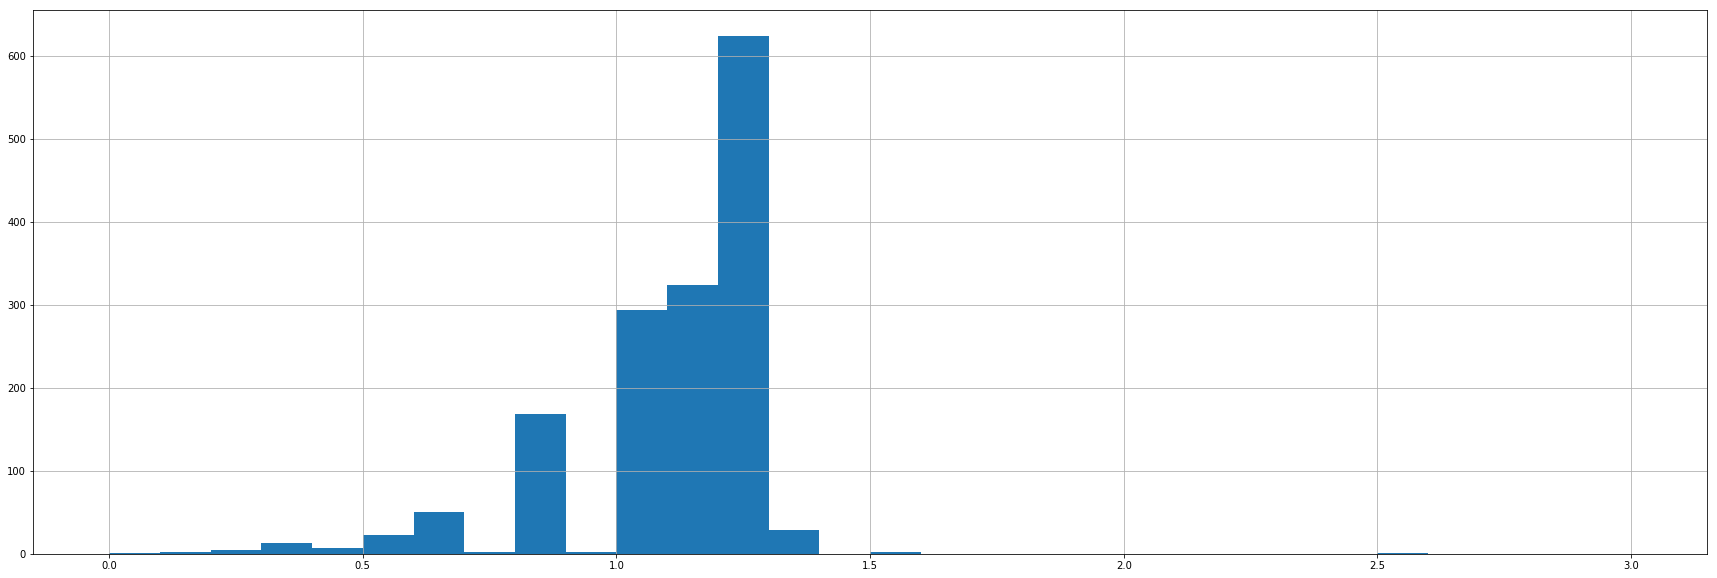

In [82]:
# 画直方图观察评分分布情况
# 左侧整体呈正态分布，均值在1.25左右
# 超过1.3分的推特数量就很少了
fig = plt.figure(figsize=(30, 10))
df_copy['rating'].hist(bins=np.linspace(0, 3, 31))

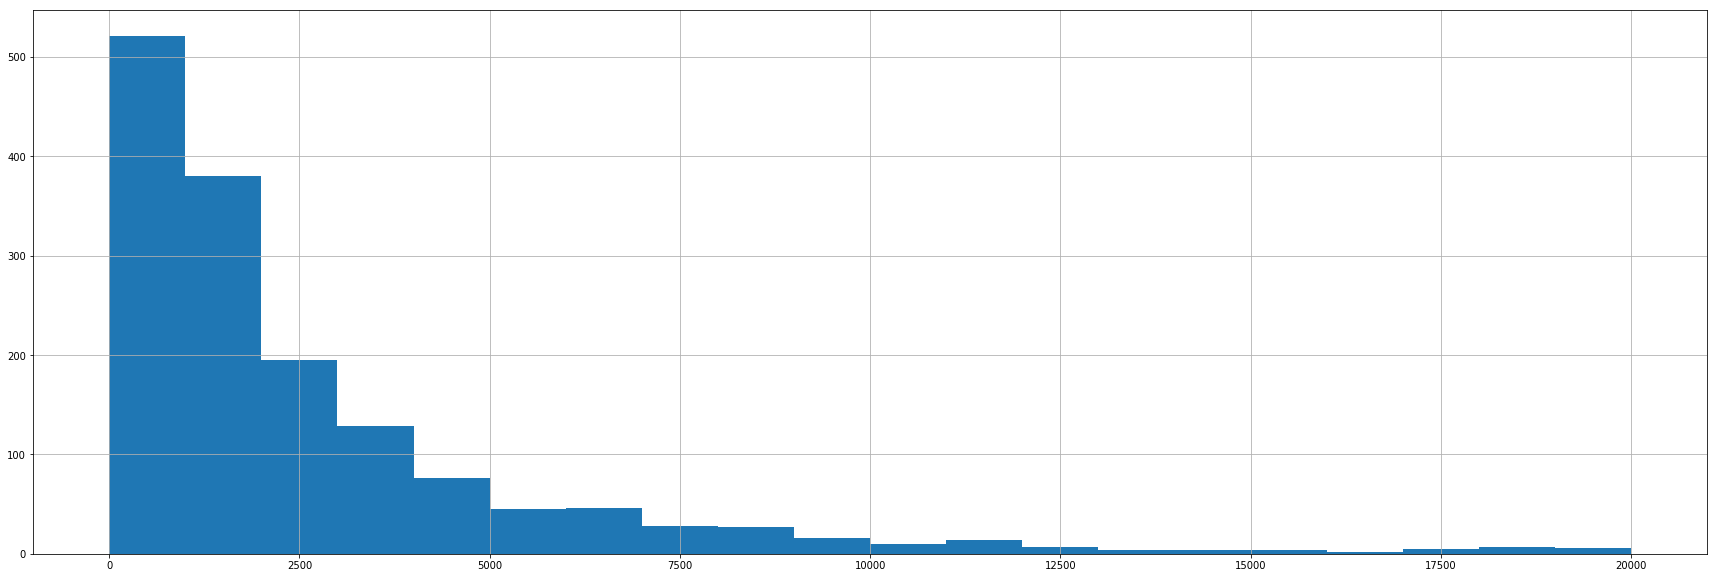

In [83]:
# 画直方图观察转发数分布情况
# 数据呈右倾斜分布
# 转发数在0到1000的推特数量最多
fig = plt.figure(figsize=(30, 10))
df_copy['retweet_count'].hist(bins=np.linspace(0, 20000, 21))

In [84]:
len(df_copy[df_copy['retweet_count']<11000])

1473

In [85]:
len(df_copy[df_copy['retweet_count']<10000])

1463

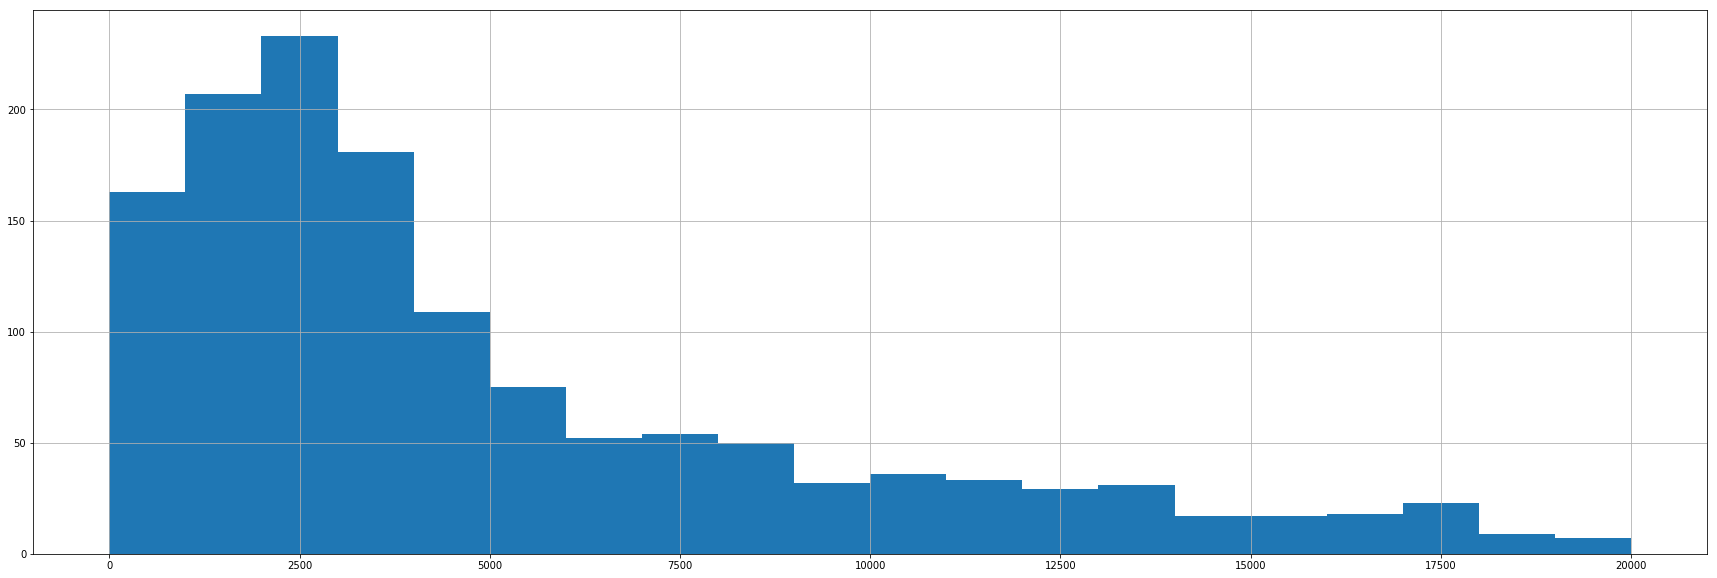

In [86]:
# 画直方图观察喜欢数分布情况
# 数据呈右倾斜分布
# 转发数在2000到2500的推特数量最多
fig = plt.figure(figsize=(30, 10))
df_copy['favorite_count'].hist(bins=np.linspace(0, 20000, 21))

In [87]:
# 画气泡图
# X轴为转发数，Y轴为喜欢数，气泡大小代表评分，分值越高气泡越大。
bubble_data = pd.DataFrame(columns=['retweet_count', 'favorite_coute', 'rating'])
bubble_data['retweet_count'] = df_copy['retweet_count']
bubble_data['favorite_coute'] = df_copy['favorite_count']
bubble_data['rating'] = df_copy['rating']

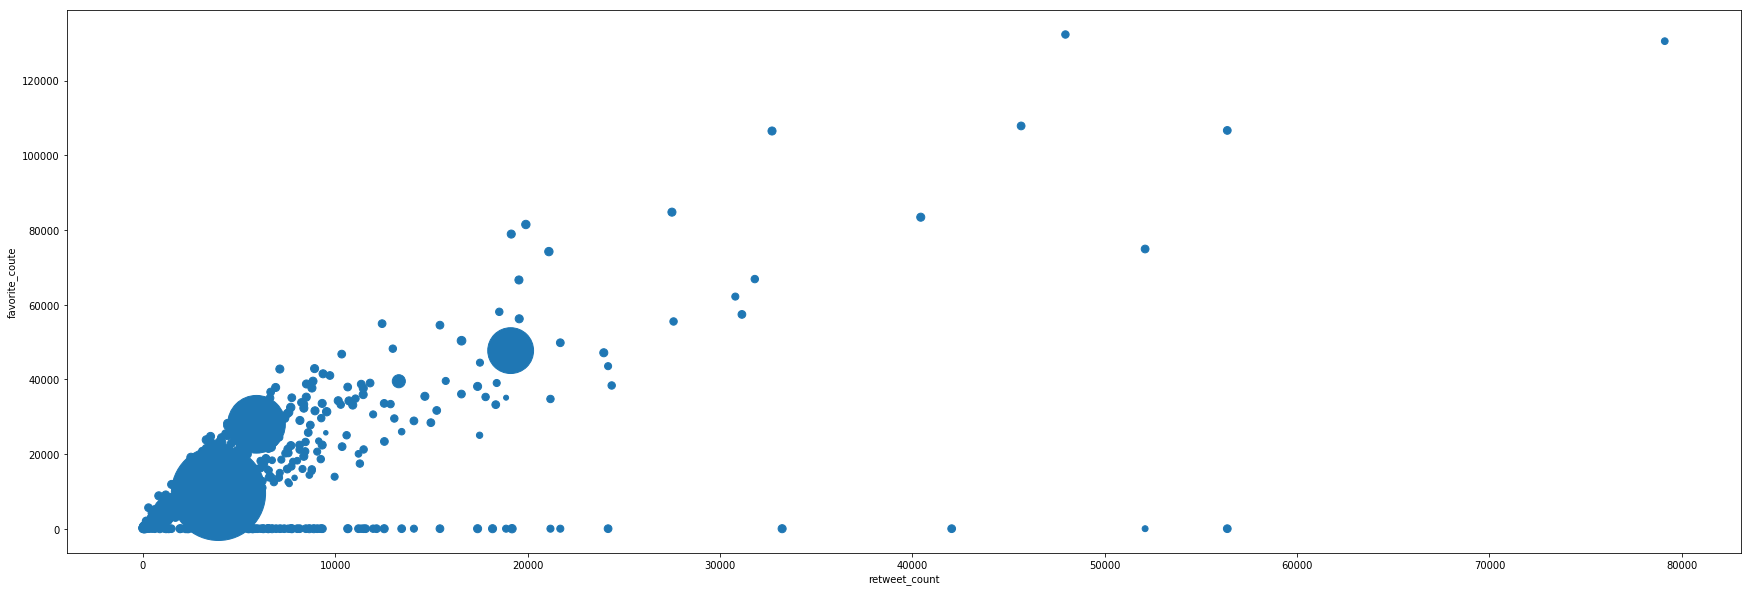

In [88]:
# 转发数和喜欢数整体呈现出正相关，
# 但是评分数与转发数或喜欢数就没有非常明显的相关性，
# 可以看到最大的三个气泡之间无论是在转发数还是喜欢数上都有比较明显的差异。
bubble_data.plot.scatter(x='retweet_count', y='favorite_coute', s=bubble_data['rating']*50, figsize=(30, 10))

# Appendix